In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz
!tar xf spark-3.2.0-bin-hadoop3.2.tgz
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.0-bin-hadoop3.2"
!pip install -q findspark
import findspark
findspark.init()

In [ ]:
import pandas as pd
from pyspark import SparkContext
from pyspark.sql import SQLContext 
sc = SparkContext("local", "App Name")

In [ ]:
sql = SQLContext(sc)
df = pd.read_excel("btc17-21_day.xlsx",sheet_name="Day")
df=sql.createDataFrame(df) 
df.show()

/content/spark-3.2.0-bin-hadoop3.2/python/pyspark/sql/context.py:79: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


+----------+------------------+---------------+---------------+------------+-------------+---------+--------------+--------------+-------------+-------------+----------+----------+-----------+-----------+----------+--------+--------+
|      time|num_not_empty_hour|      nBits_day|      value_day|in_count_day|out_count_day|count_day|volume_btc_day|volume_usd_day|value_min_day|value_max_day|in_min_day|in_max_day|out_min_day|out_max_day| Next_time|    Open|   Close|
+----------+------------------+---------------+---------------+------------+-------------+---------+--------------+--------------+-------------+-------------+----------+----------+-----------+-----------+----------+--------+--------+
|1605744000|                24|120357045062433|237845975128673|      854333|       900212|   311061|       648.258| 1.157131272E7|            0|1738730017046|         1|      1026|          1|       3678|1605830400|17801.21|17824.13|
|1605657600|                24|140069288055771|293015947122925| 

# 3 Regression Model

## Data Processing

In [ ]:
# Features engineering
from pyspark.sql import functions as F
df = (df
    .withColumn('time', df['time']+0)
    .withColumn('nBits', df['nBits_day']/df['count_day'])
    .withColumn('value', df['value_day']+0)
    .withColumn('in_count', df['in_count_day']+0)
    .withColumn('out_count', df['out_count_day']+0)
    .withColumn('count', df['count_day']+0)
    .withColumn('value_max', df['value_max_day']+0)
    .withColumn('in_max', df['in_max_day']+0)
    .withColumn('out_max', df['out_max_day']+0)
    .withColumn('Open', df['Open']+0)
    # .withColumn('value', df['value']/df['count'])
    .withColumn('Volume BTC', F.round(df['volume_btc_day'], 5))
    .withColumn('Close', df['Close']+0)
    )
df = (df
    .select(
        F.col('time'), F.col('nBits'), F.col('value'), F.col('in_count'), F.col('out_count'), F.col('count'), F.col('value_max'), 
        F.col('in_max'), F.col('out_max'), F.col('Open'), F.col('Volume BTC'), F.col('Close').alias('Target'),
    )
    )
df.show()

+----------+--------------------+---------------+--------+---------+------+-------------+------+-------+--------+----------+--------+
|      time|               nBits|          value|in_count|out_count| count|    value_max|in_max|out_max|    Open|Volume BTC|  Target|
+----------+--------------------+---------------+--------+---------+------+-------------+------+-------+--------+----------+--------+
|1605744000|        3.86924253E8|237845975128673|  854333|   900212|311061|1738730017046|  1026|   3678|17801.21|   648.258|17824.13|
|1605657600|        3.86924253E8|293015947122925| 1015425|  1017548|362007|5300188238806|  1458|   3612|17685.78|   1593.95|17801.21|
|1605571200|        3.86924253E8|303081151945984|  952473|   974192|347772|6000099293700|  1098|   3673|16722.99|   977.387|17685.78|
|1605484800| 3.869549543175676E8|361830361786069|  920102|   869288|311477|1900338360044|   984|   3641| 15975.9|   563.242|16722.99|
|1605398400|        3.86974771E8|159894568491318|  856957|   7

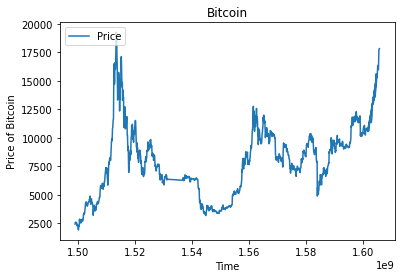

In [ ]:
import matplotlib.pyplot as plt

y = [val.Target for val in df.select('Target').collect()]
x = [val.time for val in df.select('time').collect()]

plt.plot(x, y)

plt.ylabel('Price of Bitcoin')
plt.xlabel('Time')
plt.title('Bitcoin')
plt.legend(['Price'], loc='upper left')

plt.show()

In [ ]:
# Feature aggregation
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=['time', 'nBits', 'value', 'in_count', 'out_count', 'count', 'value_max', 'in_max', 'out_max', 
                                       'Open', 'Volume BTC'], outputCol="features")
df = assembler.transform(df)
df.show()

+----------+--------------------+---------------+--------+---------+------+-------------+------+-------+--------+----------+--------+--------------------+
|      time|               nBits|          value|in_count|out_count| count|    value_max|in_max|out_max|    Open|Volume BTC|  Target|            features|
+----------+--------------------+---------------+--------+---------+------+-------------+------+-------+--------+----------+--------+--------------------+
|1605744000|        3.86924253E8|237845975128673|  854333|   900212|311061|1738730017046|  1026|   3678|17801.21|   648.258|17824.13|[1.605744E9,3.869...|
|1605657600|        3.86924253E8|293015947122925| 1015425|  1017548|362007|5300188238806|  1458|   3612|17685.78|   1593.95|17801.21|[1.6056576E9,3.86...|
|1605571200|        3.86924253E8|303081151945984|  952473|   974192|347772|6000099293700|  1098|   3673|16722.99|   977.387|17685.78|[1.6055712E9,3.86...|
|1605484800| 3.869549543175676E8|361830361786069|  920102|   869288|31

In [ ]:
# Split data into training set and testing set
# 2020-10-20(1603234800)
# 2020-08-01(1596240000)
# 2020-07-01(1593561600)
X_train = df.filter(F.col('time') < "1593561600")
X_test = df.filter(F.col('time') > "1593561600")
X_test.show()

+----------+--------------------+---------------+--------+---------+------+-------------+------+-------+--------+----------+--------+--------------------+
|      time|               nBits|          value|in_count|out_count| count|    value_max|in_max|out_max|    Open|Volume BTC|  Target|            features|
+----------+--------------------+---------------+--------+---------+------+-------------+------+-------+--------+----------+--------+--------------------+
|1605744000|        3.86924253E8|237845975128673|  854333|   900212|311061|1738730017046|  1026|   3678|17801.21|   648.258|17824.13|[1.605744E9,3.869...|
|1605657600|        3.86924253E8|293015947122925| 1015425|  1017548|362007|5300188238806|  1458|   3612|17685.78|   1593.95|17801.21|[1.6056576E9,3.86...|
|1605571200|        3.86924253E8|303081151945984|  952473|   974192|347772|6000099293700|  1098|   3673|16722.99|   977.387|17685.78|[1.6055712E9,3.86...|
|1605484800| 3.869549543175676E8|361830361786069|  920102|   869288|31

## Linear Regression Model

In [93]:
from pyspark.ml.regression import *
# Applying Linear Regression Model
lr = LinearRegression(featuresCol = 'features', labelCol="Target")
fitted_lr = lr.fit(X_train)
yhat_lr = (fitted_lr.transform(X_test))
yhat_lr.select(F.col('Target'), F.col('prediction')).show()

+--------+------------------+
|  Target|        prediction|
+--------+------------------+
|17824.13|17667.716403665014|
|17801.21| 17643.03415445339|
|17685.78|16612.817829035674|
|16722.99|15830.655606126562|
| 15975.9|15969.687429937552|
|16096.16|16233.414339109553|
|16344.16|16197.310408058212|
|16302.24| 15642.90223146052|
|15714.19|15254.203470097578|
|15323.87| 15250.95981847819|
|15332.43|15514.455605881016|
|10552.76|10576.514837443774|
| 10680.3| 10611.65786208973|
|10796.53|10645.177575392623|
| 10603.0|10784.536583947298|
|10680.18|10627.425882864114|
|10922.82|10679.885154049934|
|11064.29|10920.426040620845|
|11305.49|11032.732929695958|
|11370.79|11229.708237986793|
+--------+------------------+
only showing top 20 rows



In [94]:
# Evaluations of Linear Regression Model
from pyspark.ml.evaluation import RegressionEvaluator
eval = RegressionEvaluator(labelCol='Target', predictionCol='prediction', metricName='rmse')
rmse = eval.evaluate(yhat_lr)
print('RMSE is', rmse)
mae = eval.evaluate(yhat_lr, {eval.metricName: "mae"})
print('MAE is', mae)
r2 = eval.evaluate(yhat_lr, {eval.metricName: "r2"})
print('R² is', r2)

RMSE is 336.4749437840712
MAE is 221.96402761060594
R² is 0.9711654682477727


## Decision Tree Regressor

In [95]:
# Applying Decision Tree Regressor
dt = DecisionTreeRegressor(featuresCol = 'features', labelCol="Target")
dt.setSeed(12345678)
fitted_dt = dt.fit(X_train)
yhat_dt = (fitted_dt.transform(X_test))
yhat_dt.select(F.col('Target'), F.col('prediction')).show()

+--------+------------------+
|  Target|        prediction|
+--------+------------------+
|17824.13|14190.999999999998|
|17801.21|14190.999999999998|
|17685.78|14190.999999999998|
|16722.99|14190.999999999998|
| 15975.9|14190.999999999998|
|16096.16|14190.999999999998|
|16344.16|14190.999999999998|
|16302.24|14190.999999999998|
|15714.19|14190.999999999998|
|15323.87|14190.999999999998|
|15332.43|14190.999999999998|
|10552.76|      10347.801875|
| 10680.3|      10347.801875|
|10796.53|      10347.801875|
| 10603.0|      10347.801875|
|10680.18|      10347.801875|
|10922.82|      10347.801875|
|11064.29|11166.116250000003|
|11305.49|11166.116250000003|
|11370.79|11166.116250000003|
+--------+------------------+
only showing top 20 rows



In [96]:
# Evaluations of Decision Tree Regressor Model
from pyspark.ml.evaluation import RegressionEvaluator
eval = RegressionEvaluator(labelCol='Target', predictionCol='prediction', metricName='rmse')
rmse = eval.evaluate(yhat_dt)
print('RMSE is', rmse)
mae = eval.evaluate(yhat_dt, {eval.metricName: "mae"})
print('MAE is', mae)
r2 = eval.evaluate(yhat_dt, {eval.metricName: "r2"})
print('R² is', r2)

RMSE is 929.2339942582654
MAE is 562.9553222063105
R² is 0.7800835971044648


In [97]:
# Importance of each features in Decision Tree Regressor
import pandas as pd
score = fitted_dt.featureImportances.toArray()
features = ['time', 'nBits', 'value', 'in_count', 'out_count', 'count', 'value_max', 'in_max', 'out_max', 
                                       'Open', 'Volume BTC']
features_score = (pd.DataFrame(dict(zip(features, score)), range(1))
  .T.rename(columns={0:'Score'})
  .sort_values("Score", ascending =False)
  )
features_score

,Score
Open,0.967507
nBits,0.025293
value,0.003319
time,0.001633
in_count,0.001602
out_count,0.000468
Volume BTC,0.000117
out_max,0.000061
count,0.000000
value_max,0.000000


## Gradient Boosted Tree Regressor

In [99]:
# Applying a gradient boosted tree regressor
gbt = GBTRegressor(labelCol="Target")
gbt.setSeed(12345678)
fitted = gbt.fit(X_train)
yhat_gbt = (fitted.transform(X_test))
yhat_gbt.select(F.col('Target'), F.col('prediction')).show()

+--------+------------------+
|  Target|        prediction|
+--------+------------------+
|17824.13|13571.964341766889|
|17801.21|14679.647656031133|
|17685.78| 14654.05904914365|
|16722.99|14106.936470986804|
| 15975.9|13811.786300934862|
|16096.16|13890.389108610567|
|16344.16|13836.841920227766|
|16302.24|14847.811319754237|
|15714.19| 14682.07035098417|
|15323.87|14080.524987060551|
|15332.43| 14726.41300060577|
|10552.76|11131.297625145875|
| 10680.3|11037.149430347217|
|10796.53|10225.167967285784|
| 10603.0|10391.001728877045|
|10680.18|11288.066638502645|
|10922.82|11239.468904942722|
|11064.29|10439.592401890512|
|11305.49|11967.705521962267|
|11370.79|11306.286206463601|
+--------+------------------+
only showing top 20 rows



In [100]:
# Evaluations of gradient boosted tree regressor
from pyspark.ml.evaluation import RegressionEvaluator
eval = RegressionEvaluator(labelCol='Target', predictionCol='prediction', metricName='rmse')
rmse = eval.evaluate(yhat_gbt)
print('RMSE is', rmse)
mae = eval.evaluate(yhat_gbt, {eval.metricName: "mae"})
print('MAE is', mae)
r2 = eval.evaluate(yhat_gbt, {eval.metricName: "r2"})
print('R² is', r2)

RMSE is 973.8455171816576
MAE is 647.8165836157409
R² is 0.7584608221829989


In [101]:
# Importance of each features in GBTRegressor
import pandas as pd
score = fitted.featureImportances.toArray()
features = ['time', 'nBits', 'value', 'in_count', 'out_count', 'count', 'value_max', 'in_max', 'out_max', 
                                       'Open', 'Volume BTC']
features_score = (pd.DataFrame(dict(zip(features, score)), range(1))
  .T.rename(columns={0:'Score'})
  .sort_values("Score", ascending =False)
  )
features_score

,Score
Open,0.853107
nBits,0.028056
value,0.021070
value_max,0.016264
out_max,0.015659
in_count,0.014424
Volume BTC,0.013303
in_max,0.011498
count,0.009655
out_count,0.009268


In [102]:
# Optimise the model with Kfold and GridSearch Method(GBT)
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [5, 8, 10, 12])
             .addGrid(gbt.maxBins, [32, 64])
             .build())
cv = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=eval,
                          numFolds=3)  
cv.setSeed(12345678)
cvModel = cv.fit(X_train)
cvYhat = cvModel.transform(X_test)

cvEval = RegressionEvaluator(labelCol='Target', predictionCol='prediction', metricName='rmse')
rmse = cvEval.evaluate(cvYhat)
print('RMSE is', rmse)
mae = cvEval.evaluate(cvYhat, {cvEval.metricName: "mae"})
print('MAE is', mae)
r2 = cvEval.evaluate(cvYhat, {cvEval.metricName: "r2"})
print('R² is', r2)

cvYhat.select(F.col('Target'), F.col('prediction')).show()

RMSE is 973.8455171816576
MAE is 647.8165836157409
R² is 0.7584608221829989
+--------+------------------+
|  Target|        prediction|
+--------+------------------+
|17824.13|13571.964341766889|
|17801.21|14679.647656031133|
|17685.78| 14654.05904914365|
|16722.99|14106.936470986804|
| 15975.9|13811.786300934862|
|16096.16|13890.389108610567|
|16344.16|13836.841920227766|
|16302.24|14847.811319754237|
|15714.19| 14682.07035098417|
|15323.87|14080.524987060551|
|15332.43| 14726.41300060577|
|10552.76|11131.297625145875|
| 10680.3|11037.149430347217|
|10796.53|10225.167967285784|
| 10603.0|10391.001728877045|
|10680.18|11288.066638502645|
|10922.82|11239.468904942722|
|11064.29|10439.592401890512|
|11305.49|11967.705521962267|
|11370.79|11306.286206463601|
+--------+------------------+
only showing top 20 rows



In [104]:
# Evaluations of Cross Validation
eval = RegressionEvaluator(labelCol='Target', predictionCol='prediction', metricName='rmse')
rmse = eval.evaluate(cvYhat)
print('RMSE is', rmse)
mae = eval.evaluate(cvYhat, {eval.metricName: "mae"})
print('MAE is', mae)
r2 = eval.evaluate(cvYhat, {eval.metricName: "r2"})
print('R² is', r2)

RMSE is 973.8455171816576
MAE is 647.8165836157409
R² is 0.7584608221829989


# 3 Classification Model

## Data Processing

In [105]:
df2 = pd.read_excel("btc17-21_day.xlsx",sheet_name="Day")
df2=sql.createDataFrame(df2) 
df2.show()

+----------+------------------+---------------+---------------+------------+-------------+---------+--------------+--------------+-------------+-------------+----------+----------+-----------+-----------+----------+--------+--------+
|      time|num_not_empty_hour|      nBits_day|      value_day|in_count_day|out_count_day|count_day|volume_btc_day|volume_usd_day|value_min_day|value_max_day|in_min_day|in_max_day|out_min_day|out_max_day| Next_time|    Open|   Close|
+----------+------------------+---------------+---------------+------------+-------------+---------+--------------+--------------+-------------+-------------+----------+----------+-----------+-----------+----------+--------+--------+
|1605744000|                24|120357045062433|237845975128673|      854333|       900212|   311061|       648.258| 1.157131272E7|            0|1738730017046|         1|      1026|          1|       3678|1605830400|17801.21|17824.13|
|1605657600|                24|140069288055771|293015947122925| 

In [106]:
# Features engineering
from pyspark.sql import functions as F
df2 = (df2
    .withColumn('time', df2['time']+0)
    .withColumn('nBits', df2['nBits_day']/df2['count_day'])
    .withColumn('value', df2['value_day']+0)
    .withColumn('in_count', df2['in_count_day']+0)
    .withColumn('out_count', df2['out_count_day']+0)
    .withColumn('count', df2['count_day']+0)
    .withColumn('value_max', df2['value_max_day']+0)
    .withColumn('in_max', df2['in_max_day']+0)
    .withColumn('out_max', df2['out_max_day']+0)
    .withColumn('Open', df2['Open']+0)
    # .withColumn('value', df['value']/df['count'])
    .withColumn('Volume BTC', F.round(df2['volume_btc_day'], 5))
    .withColumn('Close', df2['Close']+0)
    )
df2 = (df2
    .select(
        F.col('time'), F.col('nBits'), F.col('value'), F.col('in_count'), F.col('out_count'), F.col('count'), F.col('value_max'), 
        F.col('in_max'), F.col('out_max'), F.col('Open'), F.col('Volume BTC'), F.col('Close').alias('Target'),
    )
    )
df2.show()

+----------+--------------------+---------------+--------+---------+------+-------------+------+-------+--------+----------+--------+
|      time|               nBits|          value|in_count|out_count| count|    value_max|in_max|out_max|    Open|Volume BTC|  Target|
+----------+--------------------+---------------+--------+---------+------+-------------+------+-------+--------+----------+--------+
|1605744000|        3.86924253E8|237845975128673|  854333|   900212|311061|1738730017046|  1026|   3678|17801.21|   648.258|17824.13|
|1605657600|        3.86924253E8|293015947122925| 1015425|  1017548|362007|5300188238806|  1458|   3612|17685.78|   1593.95|17801.21|
|1605571200|        3.86924253E8|303081151945984|  952473|   974192|347772|6000099293700|  1098|   3673|16722.99|   977.387|17685.78|
|1605484800| 3.869549543175676E8|361830361786069|  920102|   869288|311477|1900338360044|   984|   3641| 15975.9|   563.242|16722.99|
|1605398400|        3.86974771E8|159894568491318|  856957|   7

In [107]:
df2 = (df2
       .withColumnRenamed('Target', 'Close')
       .withColumn('Target', F.when(F.col('Close')-F.col('Open') > 0, 1).otherwise(0))
      ) 
df2.show()

+----------+--------------------+---------------+--------+---------+------+-------------+------+-------+--------+----------+--------+------+
|      time|               nBits|          value|in_count|out_count| count|    value_max|in_max|out_max|    Open|Volume BTC|   Close|Target|
+----------+--------------------+---------------+--------+---------+------+-------------+------+-------+--------+----------+--------+------+
|1605744000|        3.86924253E8|237845975128673|  854333|   900212|311061|1738730017046|  1026|   3678|17801.21|   648.258|17824.13|     1|
|1605657600|        3.86924253E8|293015947122925| 1015425|  1017548|362007|5300188238806|  1458|   3612|17685.78|   1593.95|17801.21|     1|
|1605571200|        3.86924253E8|303081151945984|  952473|   974192|347772|6000099293700|  1098|   3673|16722.99|   977.387|17685.78|     1|
|1605484800| 3.869549543175676E8|361830361786069|  920102|   869288|311477|1900338360044|   984|   3641| 15975.9|   563.242|16722.99|     1|
|1605398400| 

In [108]:
# Feature aggregation
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=['time', 'nBits', 'value', 'in_count', 'out_count', 'count', 'value_max', 'in_max', 'out_max', 
                                       'Open', 'Volume BTC'], outputCol="features")
df2 = assembler.transform(df2)
df2.show()

+----------+--------------------+---------------+--------+---------+------+-------------+------+-------+--------+----------+--------+------+--------------------+
|      time|               nBits|          value|in_count|out_count| count|    value_max|in_max|out_max|    Open|Volume BTC|   Close|Target|            features|
+----------+--------------------+---------------+--------+---------+------+-------------+------+-------+--------+----------+--------+------+--------------------+
|1605744000|        3.86924253E8|237845975128673|  854333|   900212|311061|1738730017046|  1026|   3678|17801.21|   648.258|17824.13|     1|[1.605744E9,3.869...|
|1605657600|        3.86924253E8|293015947122925| 1015425|  1017548|362007|5300188238806|  1458|   3612|17685.78|   1593.95|17801.21|     1|[1.6056576E9,3.86...|
|1605571200|        3.86924253E8|303081151945984|  952473|   974192|347772|6000099293700|  1098|   3673|16722.99|   977.387|17685.78|     1|[1.6055712E9,3.86...|
|1605484800| 3.8695495431756

In [117]:
# Split data into training set and testing set
# 2020-10-20(1603234800)
# 2020-08-01(1596240000)
# 2020-07-01(1593561600)
X_train = df2.filter(F.col('time') < "1593561600")
X_test = df2.filter(F.col('time') > "1593561600")
X_test.show()

+----------+--------------------+---------------+--------+---------+------+-------------+------+-------+--------+----------+--------+------+--------------------+
|      time|               nBits|          value|in_count|out_count| count|    value_max|in_max|out_max|    Open|Volume BTC|   Close|Target|            features|
+----------+--------------------+---------------+--------+---------+------+-------------+------+-------+--------+----------+--------+------+--------------------+
|1605744000|        3.86924253E8|237845975128673|  854333|   900212|311061|1738730017046|  1026|   3678|17801.21|   648.258|17824.13|     1|[1.605744E9,3.869...|
|1605657600|        3.86924253E8|293015947122925| 1015425|  1017548|362007|5300188238806|  1458|   3612|17685.78|   1593.95|17801.21|     1|[1.6056576E9,3.86...|
|1605571200|        3.86924253E8|303081151945984|  952473|   974192|347772|6000099293700|  1098|   3673|16722.99|   977.387|17685.78|     1|[1.6055712E9,3.86...|
|1605484800| 3.8695495431756

## Logistic Regression Model

In [118]:
from pyspark.ml.classification import *
logr = LogisticRegression(featuresCol = 'features', labelCol='Target', maxIter=2)
fitted_logr = logr.fit(X_train)
yhat_logr = (fitted_logr.transform(X_test))
yhat_logr.select('Target', 'rawPrediction', 'prediction', 'probability').show(10)

+------+--------------------+----------+--------------------+
|Target|       rawPrediction|prediction|         probability|
+------+--------------------+----------+--------------------+
|     1|[0.15725430840473...|       0.0|[0.53923276175912...|
|     1|[0.12883882656672...|       0.0|[0.53216522521051...|
|     1|[0.23533146898702...|       0.0|[0.55856284446245...|
|     1|[0.11001165869377...|       0.0|[0.52747521021797...|
|     0|[0.22851119879308...|       0.0|[0.55688050232829...|
|     0|[0.20323267485902...|       0.0|[0.55063400833812...|
|     1|[0.12063528174273...|       0.0|[0.53012229879844...|
|     1|[-0.0277860811174...|       1.0|[0.49305392661731...|
|     1|[0.01138705592562...|       0.0|[0.50284673322132...|
|     0|[0.07445551391538...|       0.0|[0.51860528421522...|
+------+--------------------+----------+--------------------+
only showing top 10 rows



In [119]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol = 'Target')
print('Test Area Under ROC', evaluator.evaluate(yhat_logr))

Test Area Under ROC 0.4340336134453782


## Decision Tree Classifier

In [120]:
dtc = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'Target', maxDepth = 3)
dtc.setSeed(12345678)
fitted_dtc = dtc.fit(X_train)
yhat_dtc = fitted_dtc.transform(X_test)
yhat_dtc.select('Target', 'rawPrediction', 'prediction', 'probability').show(10)

+------+-------------+----------+--------------------+
|Target|rawPrediction|prediction|         probability|
+------+-------------+----------+--------------------+
|     1|[147.0,170.0]|       1.0|[0.46372239747634...|
|     1|[147.0,170.0]|       1.0|[0.46372239747634...|
|     1|[147.0,170.0]|       1.0|[0.46372239747634...|
|     1|[147.0,170.0]|       1.0|[0.46372239747634...|
|     0|[147.0,170.0]|       1.0|[0.46372239747634...|
|     0|[147.0,170.0]|       1.0|[0.46372239747634...|
|     1|[147.0,170.0]|       1.0|[0.46372239747634...|
|     1|[147.0,170.0]|       1.0|[0.46372239747634...|
|     1|[147.0,170.0]|       1.0|[0.46372239747634...|
|     0|[147.0,170.0]|       1.0|[0.46372239747634...|
+------+-------------+----------+--------------------+
only showing top 10 rows



In [121]:
evaluator = BinaryClassificationEvaluator(labelCol = 'Target')
print('Test Area Under ROC', evaluator.evaluate(yhat_dtc))

Test Area Under ROC 0.5090336134453781


## Gradient Boosted Tree Classifier

In [122]:
# Applying a gradient boosted tree Classifier
gbtc = GBTClassifier(labelCol="Target")
gbtc.setSeed(123456)
fitted = gbtc.fit(X_train)
yhat_gbtc = (fitted.transform(X_test))
yhat_gbtc.select('Target', 'rawPrediction', 'prediction', 'probability').show(10)

+------+--------------------+----------+--------------------+
|Target|       rawPrediction|prediction|         probability|
+------+--------------------+----------+--------------------+
|     1|[0.64473899284683...|       0.0|[0.78405881973456...|
|     1|[1.38064700728253...|       0.0|[0.94054803325580...|
|     1|[0.42817974208620...|       0.0|[0.70189948551258...|
|     1|[1.25223484980127...|       0.0|[0.92445456910647...|
|     0|[0.63217634998476...|       0.0|[0.77977449073481...|
|     0|[-0.1487594302880...|       1.0|[0.42616413008084...|
|     1|[0.62903498613886...|       0.0|[0.77869368533976...|
|     1|[0.50679881023198...|       0.0|[0.73372361886596...|
|     1|[0.44224954863057...|       0.0|[0.70775367628114...|
|     0|[0.49425128241743...|       0.0|[0.72879204942423...|
+------+--------------------+----------+--------------------+
only showing top 10 rows



In [123]:
evaluator = BinaryClassificationEvaluator(labelCol = 'Target')
print('Test Area Under ROC', evaluator.evaluate(yhat_gbtc))

Test Area Under ROC 0.5044117647058826


### Optimise the model with Kfold and GridSearch Method(GBT)

In [124]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(gbtc.maxDepth, [2, 4, 6])
             .addGrid(gbtc.maxBins, [20, 60])
             .addGrid(gbtc.maxIter, [10, 20])
             .build())
cvc = CrossValidator(estimator=gbtc, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3)
cvc.setSeed(12345678)
cvcModel = cvc.fit(X_train)
yhat_cvc = cvcModel.transform(X_test)
yhat_cvc.select('Target', 'rawPrediction', 'prediction', 'probability').show(10)

+------+--------------------+----------+--------------------+
|Target|       rawPrediction|prediction|         probability|
+------+--------------------+----------+--------------------+
|     1|[-0.2097244647630...|       1.0|[0.39664862397659...|
|     1|[0.18561825823369...|       0.0|[0.59175773058091...|
|     1|[0.18561825823369...|       0.0|[0.59175773058091...|
|     1|[0.30271554047080...|       0.0|[0.64689786673930...|
|     0|[-0.2458725405516...|       1.0|[0.37948255739484...|
|     0|[-0.2091573669567...|       1.0|[0.39692008975375...|
|     1|[0.11370140983021...|       0.0|[0.55660697636911...|
|     1|[-0.2097244647630...|       1.0|[0.39664862397659...|
|     1|[-0.2097244647630...|       1.0|[0.39664862397659...|
|     0|[0.11370140983021...|       0.0|[0.55660697636911...|
+------+--------------------+----------+--------------------+
only showing top 10 rows



In [125]:
evaluator = BinaryClassificationEvaluator(labelCol = 'Target')
print('Test Area Under ROC', evaluator.evaluate(yhat_cvc))

Test Area Under ROC 0.48897058823529427
